In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import json

CHESSBOARD1 = (6, 8)  # PROVIDED
CHESSBOARD2 = (4, 6)  # SELF CLICKED

### Automatic ChessBoard Corners Detection 

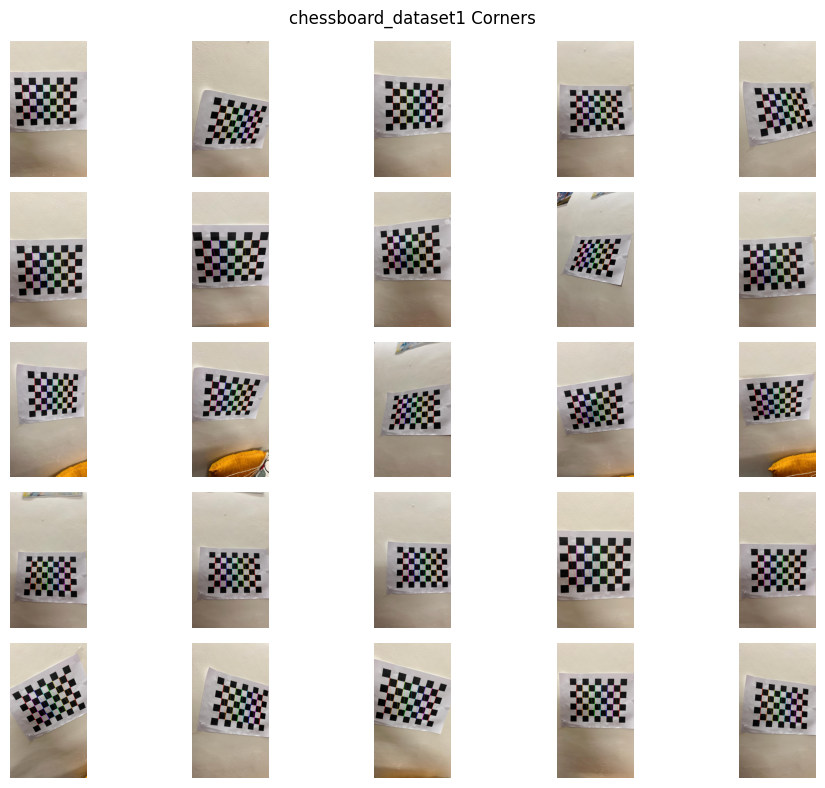

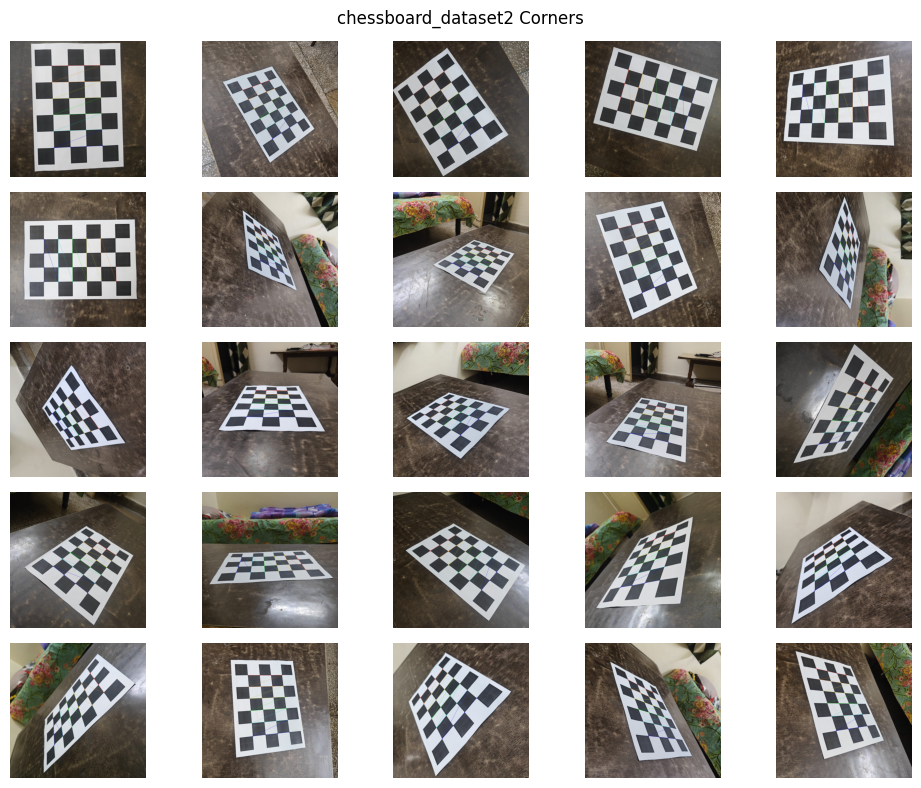

In [2]:
def detect_corners(image_folder, chessboard_patter, verbose=False, draw=False):
    objpoints = []  # 3D points in real-world space
    imgpoints = []  # 2D points in image plane
    
    # Define the chessboard size (adjust based on your calibration pattern)
    objp = np.zeros((chessboard_patter[0] * chessboard_patter[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:chessboard_patter[0], 0:chessboard_patter[1]].T.reshape(-1, 2)
    
    # Get list of images in the folder
    image_files = [f for f in os.listdir(image_folder)]

    if draw:
        plt.figure(figsize=(10, 8))  # Create a figure before 
        plt.suptitle(f"{image_folder} Corners")
    
    for i, fname in enumerate(image_files):
        img_path = os.path.join(image_folder, fname)
        image = cv2.imread(img_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, chessboard_patter, None)
        
        if ret:
            if verbose:
                print(f"Corners Detected : {fname}")
            objpoints.append(objp)
            imgpoints.append(corners)
            
            cv2.drawChessboardCorners(image, chessboard_patter, corners, ret)  # Draw corners
            
            if draw:
                plt.subplot(5, 5, i + 1)  # Plot each detected image in a grid
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.axis('off')

        else:
            if verbose:
                print(f"Failed to detect corners: {fname}")

    if draw:
        plt.tight_layout()
        plt.show()  # Show all images at once
    
    return objpoints, imgpoints

# Example usage
objpoints1, imgpoints1 = detect_corners('chessboard_dataset1', CHESSBOARD1, draw=True)
objpoints2, imgpoints2 = detect_corners('chessboard_dataset2', CHESSBOARD2, draw=True)

### Camera Calibration & Reprojection Error

In [22]:
def reprojection_errors(objectPoints, imagePoints, K, dist, rvecs, tvecs):
    errors = []
    for objpoint, imgpoint, rvec, tvec in zip(objectPoints, imagePoints, rvecs, tvecs):
        # Project 3D points to 2D
        projected_points, _ = cv2.projectPoints(objpoint, rvec, tvec, K, dist)
        # Calculate the error
        error = cv2.norm(imgpoint, projected_points, cv2.NORM_L2) / len(projected_points)
        errors.append(error)

    return np.array(errors)

def calibrate_camera(image_folder, objectPoints, imagePoints):
    # Load the first image to get the actual image size
    first_image_path = os.path.join(image_folder, os.listdir(image_folder)[0])
    first_image = cv2.imread(first_image_path)
    image_size = (first_image.shape[1], first_image.shape[0])  # (width, height)
    
    # Camera calibration
    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objectPoints, imagePoints, image_size, None, None)
    
    # Calculate reprojection errors
    errors = reprojection_errors(objectPoints, imagePoints, K, dist, rvecs, tvecs)
    
    # Prepare JSON data
    calibration_data = {
        "intrinsic_parameters": {
            "focal_length": [K[0, 0], K[1, 1]], # fx, fy
            "skew": K[0, 1], # Camera skew
            "principal_point": [K[0, 2], K[1, 2]] # cx, cy
        },
        "extrinsic_parameters": [
            {
                "image_id": i + 1,
                "rotation_matrix": cv2.Rodrigues(rvec)[0].tolist(), # Convert rotation vector to matrix
                "translation_vector": tvec.flatten().tolist() # Flatten translation vector
            }
            for i, (rvec, tvec) in enumerate(zip(rvecs, tvecs))
        ],
        "radial_distortion_coefficients": [dist[0,0], dist[0,1], dist[0,4]], # k1, k2, k3 (radial coeff) # p1, p2 (tangential coeff)
        "reprojection_errors": {
            "mean_error": np.mean(errors),
            "std_dev": np.std(errors),
        }
    }
    
    # Save JSON file
    with open(f"{image_folder}_calibrated.json", "w") as json_file:
        json.dump(calibration_data, json_file, indent=4)
    
    return K, dist, rvecs, tvecs, errors 

K1, dist1, rvecs1, tvecs1, errors1 = calibrate_camera('chessboard_dataset1', objpoints1, imgpoints1)
K2, dist2, rvecs2, tvecs2, errors2 = calibrate_camera('chessboard_dataset2', objpoints2, imgpoints2)

### 1. Intrinsic Camera Parameters
#### Dataset 1 (Provided)

In [23]:
print("fx, fy :", K1[0, 0], K1[1, 1])
print("skew :", K1[0, 1])
print("cx, cy :", K1[0, 2], K1[1, 2])   

fx, fy : 955.9831309528636 956.7749752283094
skew : 0.0
cx, cy : 368.88206140847524 648.8286752813


#### Dataset 2 (Self Clicked)

In [24]:
print("fx, fy :", K2[0, 0], K2[1, 1])
print("skew :", K2[0, 1])
print("cx, cy :", K2[0, 2], K2[1, 2])

fx, fy : 1459.6591988782702 1458.1478364838722
skew : 0.0
cx, cy : 783.519188003288 738.2615409886507


### 2. Extrinsic Camera Parameters
#### Dataset 1 (Provided)

In [25]:
for i in range(2):
    print("Image ID:", i + 1)
    print("Rotation Matrix: \n", cv2.Rodrigues(rvecs1[i])[0])
    print("Translation Vector: ", tvecs1[i].flatten())

Image ID: 1
Rotation Matrix: 
 [[ 0.01389117 -0.99696989 -0.076538  ]
 [ 0.98896274  0.0249913  -0.14604153]
 [ 0.14751179 -0.07366454  0.98631324]]
Translation Vector:  [ 3.04338964 -3.75226511 15.17125353]
Image ID: 2
Rotation Matrix: 
 [[ 0.242051    0.89020748 -0.38592999]
 [-0.94345703  0.12309245 -0.3077939 ]
 [-0.22649536  0.43861018  0.86966716]]
Translation Vector:  [-2.70414834  4.09783203 15.03440681]


#### Dataset 2 (Self Clicked)

In [26]:
for i in range(2):
    print("Image ID:", i + 1)
    print("Rotation Matrix: \n", cv2.Rodrigues(rvecs2[i])[0])
    print("Translation Vector: ", tvecs2[i].flatten())

Image ID: 1
Rotation Matrix: 
 [[ 0.99757039  0.0301895  -0.06278457]
 [-0.02862336  0.99925992  0.02569651]
 [ 0.06351387 -0.02383697  0.99769624]]
Translation Vector:  [-1.70164878 -2.47150213  8.05453054]
Image ID: 2
Rotation Matrix: 
 [[ 0.77430167  0.53011168 -0.34559879]
 [-0.38743648  0.82892792  0.40344948]
 [ 0.50034977 -0.17849402  0.84722488]]
Translation Vector:  [-2.56072571 -1.45048045 11.69053884]


### 3. Radial Distortion Coefficients

In [27]:
def undistort_images(image_folder, K, dist, num_images=5):
    # Get image paths
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]
    image_files = image_files[:num_images]  # Select only first `num_images`

    plt.figure(figsize=(10, 8))
    plt.suptitle(f"{image_folder} Undistorted Images")

    for i, fname in enumerate(image_files):
        img_path = os.path.join(image_folder, fname)
        img = cv2.imread(img_path)

        # Undistort the image
        undistorted_img = cv2.undistort(img, K, dist, None, K)

        # Plot original vs undistorted images side by side
        plt.subplot(2, num_images, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Original: {fname}")
        plt.axis('off')     

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Undistorted: {fname}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#### Dataset 1 (Provided)

Distortion coefficients:  [[ 0.21565351 -1.03904569  0.0027891   0.00682133  1.58635031]]


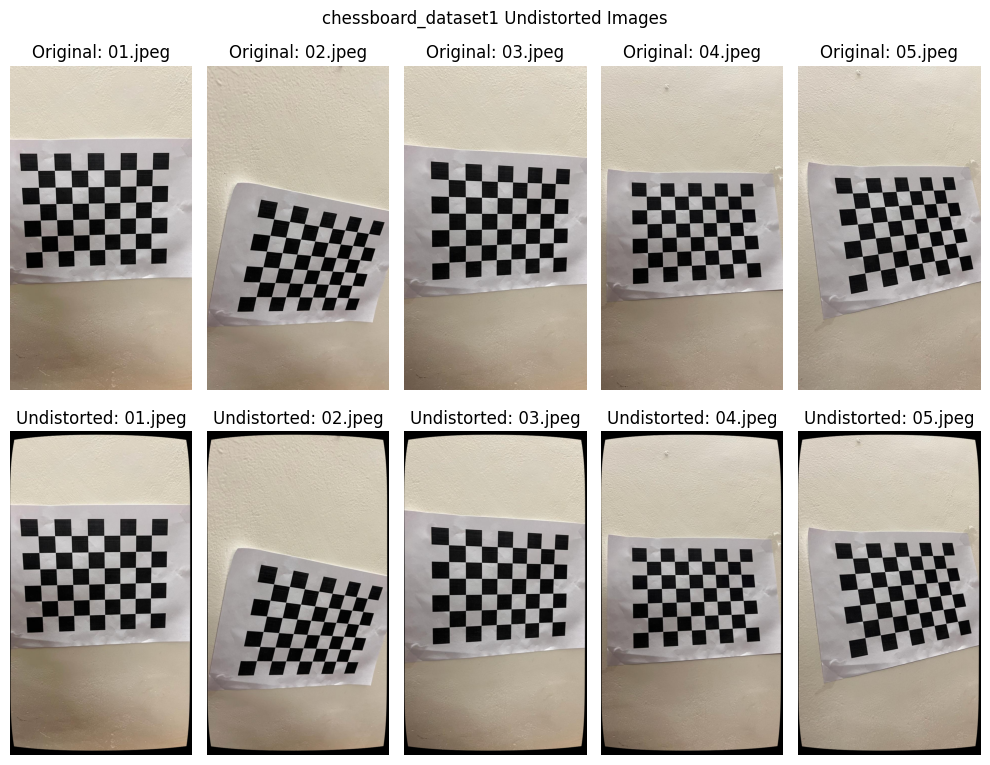

In [28]:
print("Distortion coefficients: ", dist1)
undistort_images('chessboard_dataset1', K1, dist1, num_images=5)

#### Dataset 2 (Self Clicked)

Distortion coefficients:  [[ 3.20436629e-01 -2.34227577e+00 -8.49016273e-03  4.82851853e-03
   6.49099743e+00]]


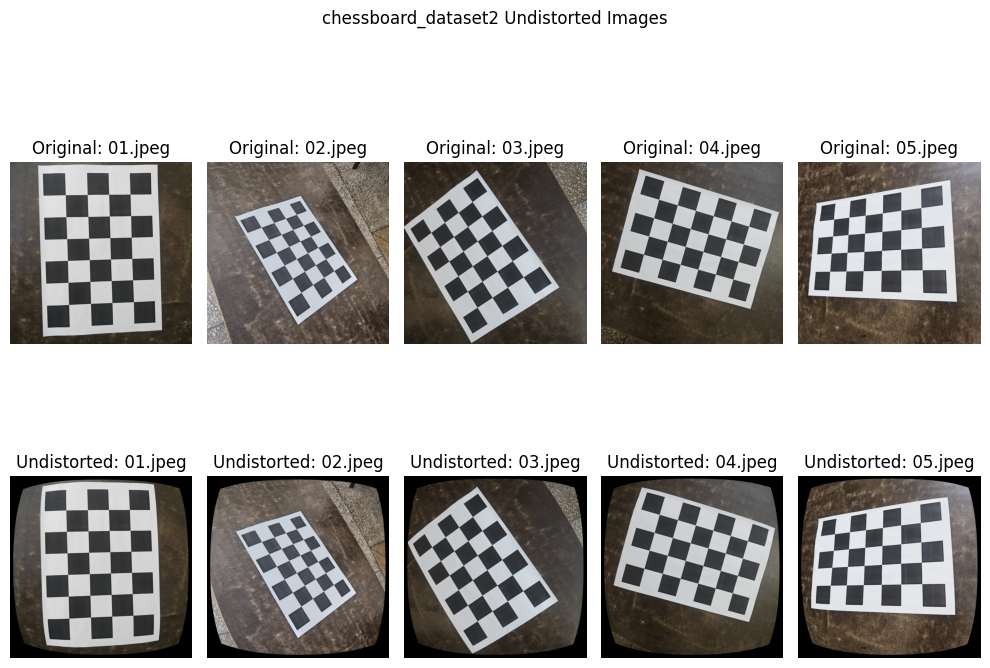

In [29]:
print("Distortion coefficients: ", dist2)
undistort_images('chessboard_dataset2', K2, dist2, num_images=5)

### 4. Reprojection Error

In [30]:
def Visualize_error(errors):
    num_images = len(errors)
    mean_error = np.mean(errors)
    std_dev = np.std(errors)

    plt.figure(figsize=(12, 6))
    plt.bar(range(1, num_images + 1), errors, color='skyblue', label="Re-projection Error")
    
    # Mean Error Line
    plt.axhline(y=mean_error, color='r', linestyle='--', label=f"Mean: {mean_error:.4f}")

    # Standard Deviation Line
    plt.axhline(y=mean_error + std_dev, color='g', linestyle='--', label=f"+1 Std Dev: {mean_error + std_dev:.4f}")
    plt.axhline(y=mean_error - std_dev, color='g', linestyle='--', label=f"-1 Std Dev: {mean_error - std_dev:.4f}")

    plt.xlabel("Image")
    plt.ylabel("Re-projection Error")
    plt.title("Re-projection Error for Each Image")
    plt.xticks(range(1, num_images + 1))  # Set x-axis labels as image indices
    plt.legend()
    plt.show()

#### Dataset 1 (Provided)

[0.04834708 0.12252298 0.0767687  0.06594681 0.11313981 0.06232144
 0.09731898 0.05247232 0.10364209 0.04492355 0.09541289 0.10373358
 0.09867753 0.08114601 0.08614456 0.05485417 0.05065939 0.0523607
 0.0657168  0.05471184 0.05399372 0.10678754 0.07906042 0.03701477
 0.06702289]
Mean Reprojection Error: 0.07498802315303951
Standard Deviation of Reprojection Error: 0.023956747838967504


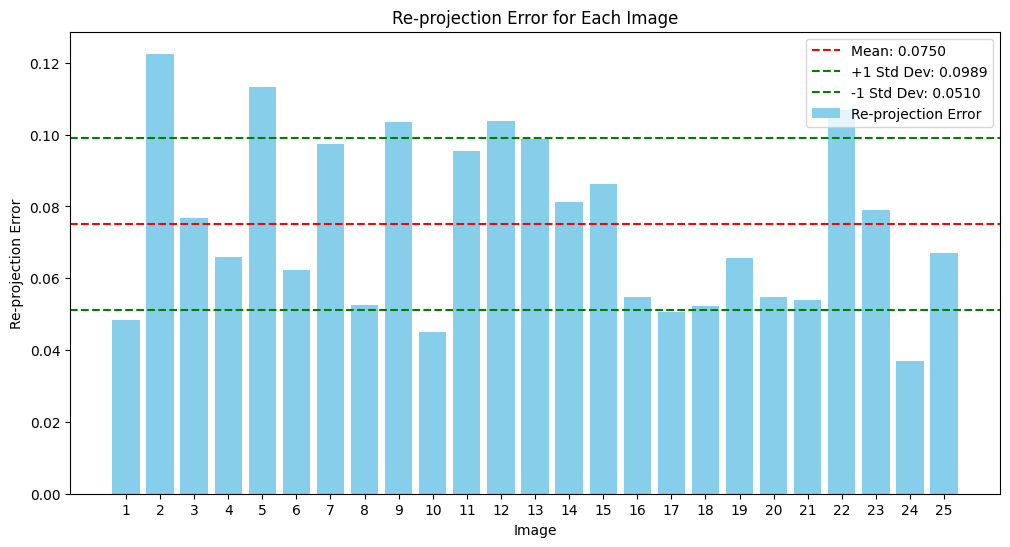

In [31]:
print(errors1)
print("Mean Reprojection Error:", np.mean(errors1))
print("Standard Deviation of Reprojection Error:", np.std(errors1))
Visualize_error(errors1)

#### Dataset 2 (Self Clicked)

[0.26973014 0.11495426 0.15707367 0.25287859 0.19482172 0.19358058
 0.37930316 0.19710415 0.16288032 0.31342164 0.27195573 0.34869904
 0.23869214 0.19829061 0.31146482 0.21072385 0.31166255 0.21806065
 0.35199028 0.36993559 0.34166112 0.14035206 0.33341657 0.31040949
 0.28305135]
Mean Reprojection Error: 0.2590445629091397
Standard Deviation of Reprojection Error: 0.07554113205305335


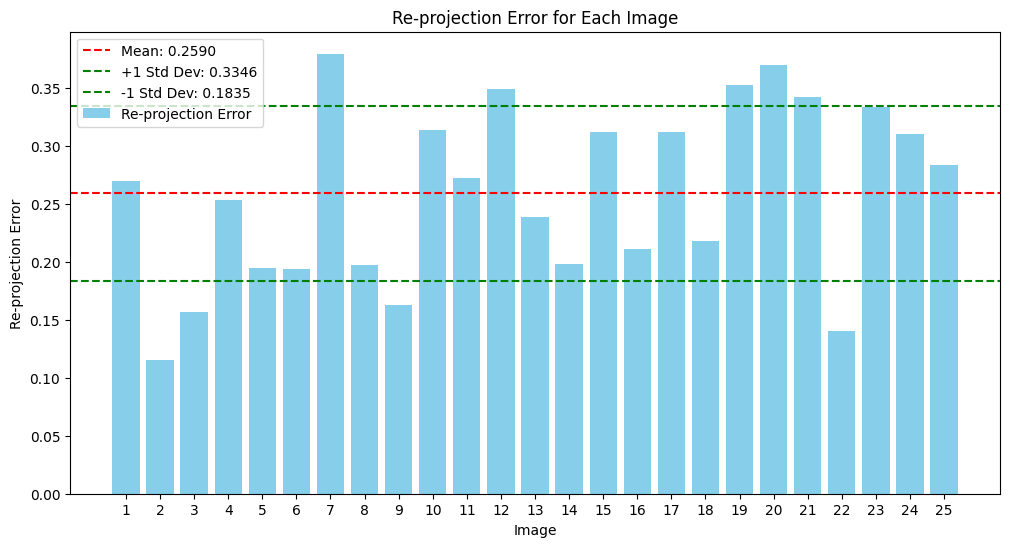

In [32]:
print(errors2)
print("Mean Reprojection Error:", np.mean(errors2))
print("Standard Deviation of Reprojection Error:", np.std(errors2))
Visualize_error(errors2)

### 5. Reprojected Corners

In [33]:
def visualize_projected_corners(image_folder, objectPoints, imagePoints, K, dist, rvecs, tvecs):
    image_files = [f for f in os.listdir(image_folder) ]

    plt.figure(figsize=(10, 8))
    plt.suptitle(f"{image_folder} Projected Corners")

    for i, fname in enumerate(image_files):
        img_path = os.path.join(image_folder, fname)
        img = cv2.imread(img_path)
        corners = imagePoints[i].reshape(-1, 2)
        # Project the 3D points to 2D
        projections, _ = cv2.projectPoints(objectPoints[i], rvecs[i], tvecs[i], K, dist)
        projections = projections.reshape(-1, 2)

        # Plot the image with projected corners
        plt.subplot(5,5, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.scatter(corners[:, 0], corners[:, 1], s=5, color="red", marker="x") # Original corners in red
        plt.scatter(projections[:, 0], projections[:, 1], s=1, facecolors="none", edgecolors="blue", marker="o") # Projected corners in blue
        plt.axis("off")

    plt.tight_layout()
    plt.show()

#### Dataset 1 (Provided)

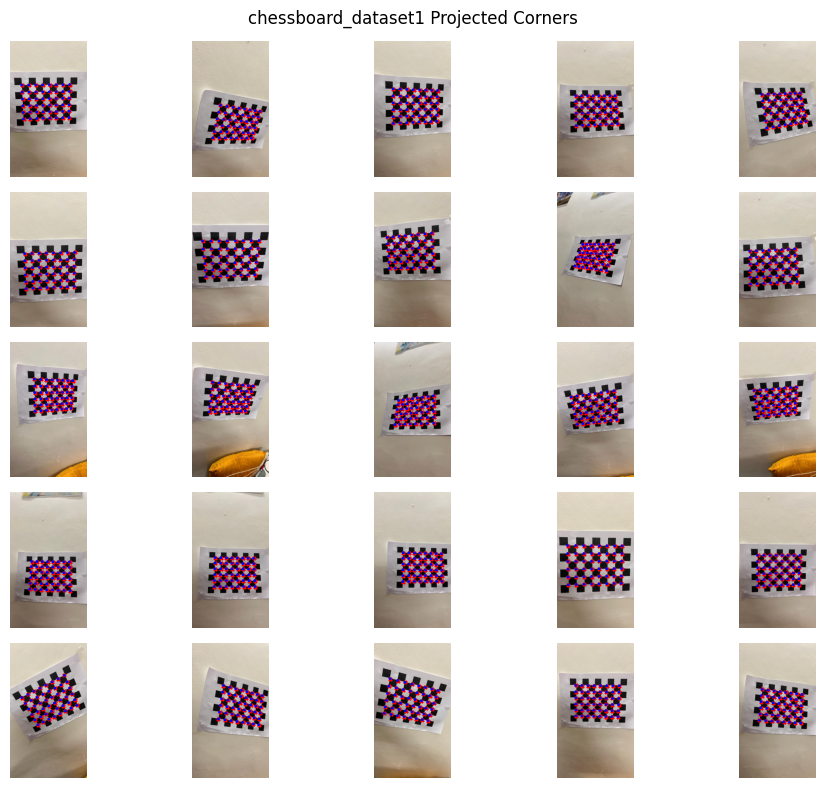

In [34]:
visualize_projected_corners('chessboard_dataset1', objpoints1, imgpoints1, K1, dist1, rvecs1, tvecs1)

#### Dataset 2 (Self Clicked)

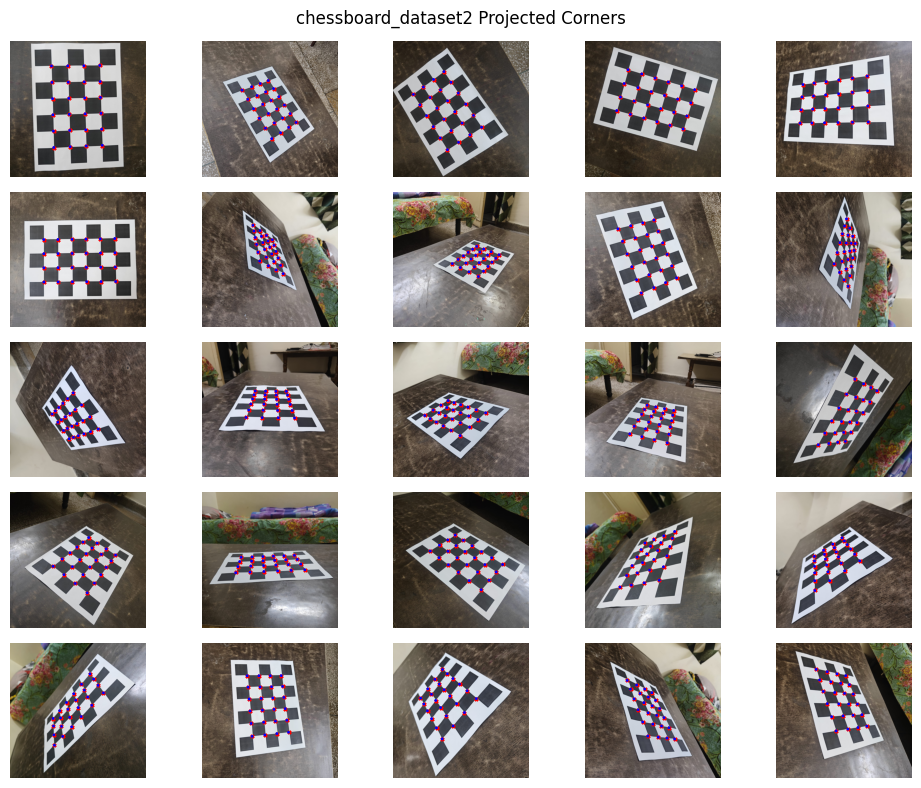

In [35]:
visualize_projected_corners('chessboard_dataset2', objpoints2, imgpoints2, K2, dist2, rvecs2, tvecs2)

#### 6. ChessBoard Plane Normal

In [36]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

def get_normals(image_folder, imagePoints, rvecs, draw=False):
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]
    normal_vectors = {}

    if draw:
        plt.figure(figsize=(10, 8))
        plt.suptitle(f"{image_folder} Normals")

    for i, fname in enumerate(image_files):
        img_path = os.path.join(image_folder, fname)
        img = cv2.imread(img_path)
        h, w = img.shape[:2]

        # Compute the normal vector from the rotation matrix
        R, _ = cv2.Rodrigues(rvecs[i])
        normal_vector = R[:, 2]  # Extract the Z-axis (normal to the board)

        # Normalize
        normal_vector /= np.linalg.norm(normal_vector)

        # Get the center of detected corners
        corners = imagePoints[i].reshape(-1, 2)
        center = np.mean(corners, axis=0).astype(int)

        # Convert normal vector to image scale
        arrow_start = center
        arrow_end = center - (normal_vector[:2] * 500).astype(int)  # Scale for visibility

        # Store the normal
        normal_vectors[fname] = normal_vector

        # Draw visualization
        if draw:
            plt.subplot(5, 5, i + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.arrow(arrow_start[0], arrow_start[1], 
                        arrow_end[0] - arrow_start[0], arrow_end[1] - arrow_start[1], 
                        color='red', head_width=50, head_length=50)
            plt.scatter(center[0], center[1], s=1, color="blue", marker="x")
            plt.axis('off')

    if draw:
        plt.tight_layout()
        plt.show()

    return normal_vectors

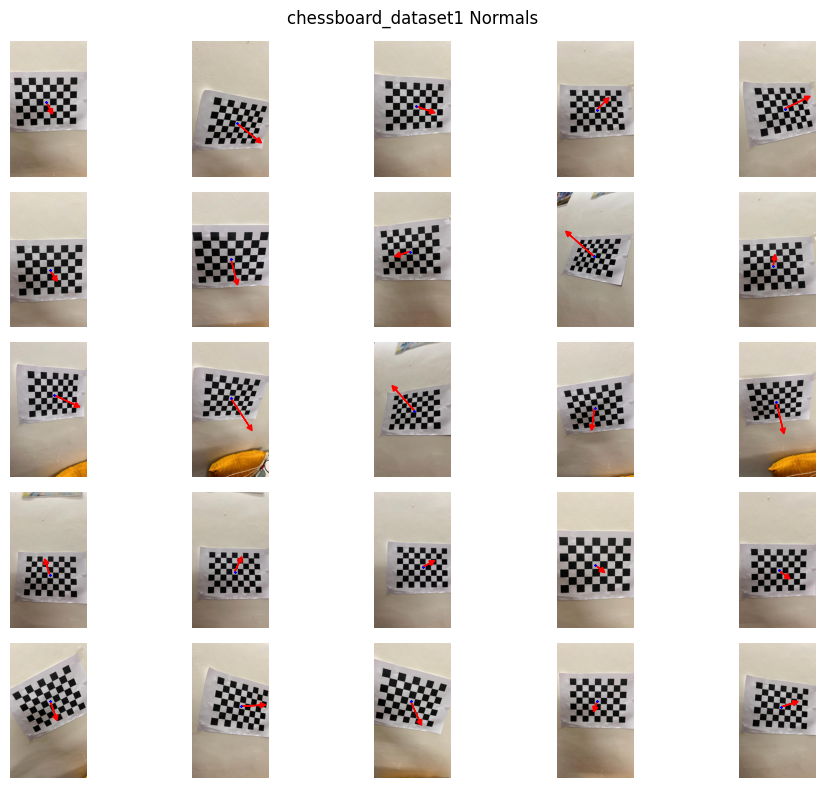

Normals for chessboard_dataset1:
01.jpeg: [-0.076538   -0.14604153  0.98631324]
02.jpeg: [-0.38592999 -0.3077939   0.86966716]
03.jpeg: [-0.27055961 -0.09590413  0.95791435]
04.jpeg: [-0.1653953   0.16256523  0.97273683]
05.jpeg: [-0.39753818  0.19242226  0.89718285]
06.jpeg: [-0.08367039 -0.12463089  0.98866901]
07.jpeg: [-0.10263416 -0.39925968  0.91107515]
08.jpeg: [ 0.18868403 -0.06357902  0.97997757]
09.jpeg: [0.45469862 0.40251032 0.79450274]
10.jpeg: [-0.02246819  0.12531503  0.99186255]
11.jpeg: [-0.39772957 -0.18595194  0.8984615 ]
12.jpeg: [-0.34642843 -0.52643739  0.77643481]
13.jpeg: [0.35757134 0.40152017 0.84316327]
14.jpeg: [ 0.04556911 -0.32149701  0.94581347]
15.jpeg: [-0.12740264 -0.50540119  0.85342733]
16.jpeg: [0.07218465 0.21920203 0.97300557]
17.jpeg: [-0.0964072   0.20029279  0.97498126]
18.jpeg: [-0.14471238  0.07615739  0.98653858]
19.jpeg: [-0.10791346 -0.08528305  0.99049558]
20.jpeg: [-0.13523341 -0.1051928   0.98521388]
21.jpeg: [-0.0966026  -0.27261542  0

In [37]:
normals = get_normals('chessboard_dataset1', imgpoints1, rvecs1, draw=True)
print("Normals for chessboard_dataset1:")
for fname, normal in normals.items():
    print(f"{fname}: {normal}")

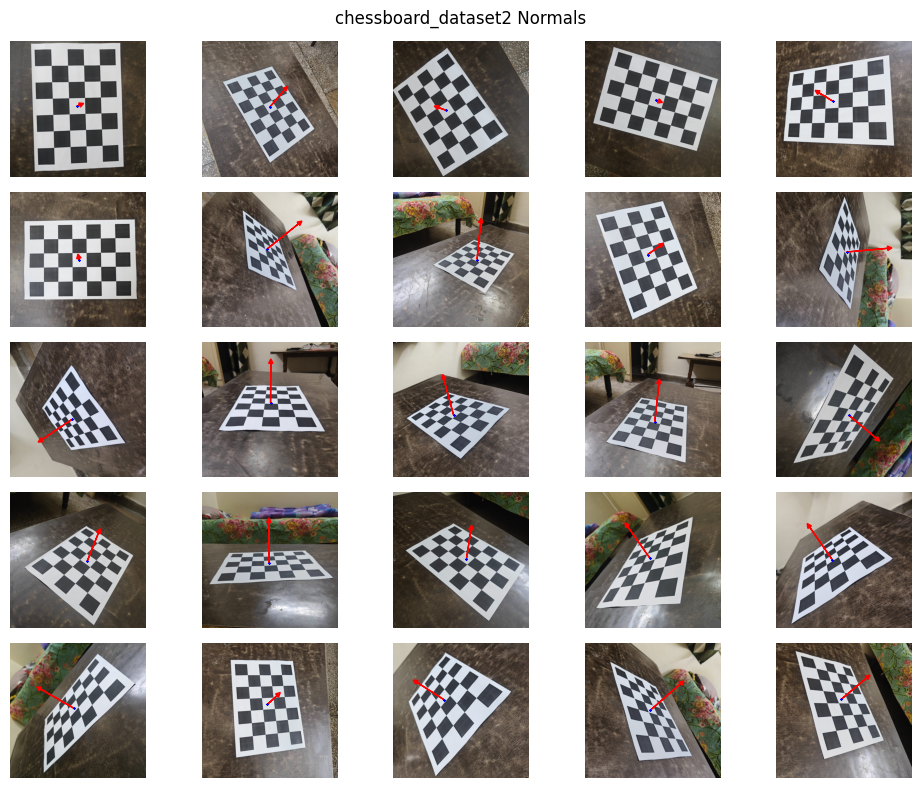

Normals for chessboard_dataset2:
01.jpeg: [-0.06278457  0.02569651  0.99769624]
02.jpeg: [-0.34559879  0.40344948  0.84722488]
03.jpeg: [0.1772606  0.06259997 0.98217103]
04.jpeg: [-0.05963651 -0.02281741  0.99795934]
05.jpeg: [0.32333138 0.19720063 0.92550998]
06.jpeg: [0.01079596 0.04798995 0.99878947]
07.jpeg: [-0.71524066  0.57278574  0.40043388]
08.jpeg: [-0.08360447  0.83944486  0.53697544]
09.jpeg: [-0.27924782  0.19839354  0.93950022]
10.jpeg: [-0.93357093  0.08523494  0.34810964]
11.jpeg: [ 0.68213722 -0.46090917  0.56767205]
12.jpeg: [-0.00788593  0.89884224  0.43820137]
13.jpeg: [0.22458534 0.82935108 0.51160357]
14.jpeg: [-0.0933827   0.86497577  0.49304826]
15.jpeg: [-0.62256443 -0.52323433  0.58192729]
16.jpeg: [-0.25833456  0.64846575  0.71606943]
17.jpeg: [0.0066086  0.92901596 0.36998063]
18.jpeg: [-0.10341584  0.66774404  0.73717234]
19.jpeg: [0.5108402 0.7255826 0.4610555]
20.jpeg: [0.51079625 0.73741645 0.44193231]
21.jpeg: [0.75602538 0.43697875 0.48731427]
22.jpeg

In [38]:
normals2 = get_normals('chessboard_dataset2', imgpoints2, rvecs2, draw=True)
print("Normals for chessboard_dataset2:")
for fname, normal in normals2.items():
    print(f"{fname}: {normal}")
    